# Notebook: Movie Recommendation System

## Library Import and Data Ingestion

In [2]:
!pip install surprise

  error: subprocess-exited-with-error
  
  exit code: 1
  
  [115 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build\lib.win-amd64-cpython-38\surprise
  copying surprise\accuracy.py -> build\lib.win-amd64-cpython-38\surprise
  copying surprise\builtin_datasets.py -> build\lib.win-amd64-cpython-38\surprise
  copying surprise\dataset.py -> build\lib.win-amd64-cpython-38\surprise
  copying surprise\dump.py -> build\lib.win-amd64-cpython-38\surprise
  copying surprise\reader.py -> build\lib.win-amd64-cpython-38\surprise
  copying surprise\trainset.py -> build\lib.win-amd64-cpython-38\surprise
  copying surprise\utils.py -> build\lib.win-amd64-cpython-38\surprise
  copying surprise\__init__.py -> build\lib.win-amd64-cpython-38\surprise
  copying surprise\__main__.py -> build\lib.win-amd64-cpython-38\surprise
  creating build\lib.win-amd64-cpython-38\surprise\model_selection
  copying surprise\model_selection\search.py -> build\lib.win-amd64-cpython-38


  Obtaining dependency information for surprise from https://files.pythonhosted.org/packages/61/de/e5cba8682201fcf9c3719a6fdda95693468ed061945493dea2dd37c5618b/surprise-0.1-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/154.4 kB ? eta -:--:--
     -- ------------------------------------- 10.2/154.4 kB ? eta -:--:--
     --------- --------------------------- 41.0/154.4 kB 393.8 kB/s eta 0:00:01
     -------------------------------------- 154.4/154.4 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Using cached surprise-0.1-py2.py3-none-any.whl (1.8 kB)
Failed to build scikit-surprise


In [9]:
from IPython.display import Image, HTML
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [10]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
df=pd.read_csv('movies_metadata.csv')
df.head()

In [ ]:
import ast

def get_primary_genre(genres_list):
    # Check if the genre list is not empty
    if genres_list and isinstance(genres_list, list):
        # Extract the name of the first genre in the list
        return genres_list[0]['name'] if 'name' in genres_list[0] else 'Unknown'
    else:
        # Return 'Unknown' if the list is empty or not a list
        return 'Unknown'

# Assuming 'df' is your DataFrame and 'genres' is the column with genres data
# The genres column contains strings that need to be converted to lists of dictionaries
# We use ast.literal_eval to safely evaluate the string as a Python expression
df['primary_genre'] = df['genres'].apply(lambda x: get_primary_genre(ast.literal_eval(x)))


In [ ]:
df['primary_genre']

In [ ]:
aver=pd.read_csv('ratings_small.csv')

In [ ]:
aver.head(30)
aver.info()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TPS predictivo avanzado /TP2/Data_Pelis/movies_metadata.csv')
df.head()

data = df

In [ ]:
df.columns

In [ ]:
df.shape

In [ ]:
df.info()

## Feature engineering

In [ ]:
df = df.drop(['imdb_id'], axis=1)

In [ ]:
df[df['original_title'] != df['title']][['title', 'original_title']].head()

In [ ]:
df = df.drop('original_title', axis=1)

In [ ]:
#porcentaje de peliculas sin revenue
(df[df['revenue'] == 0].shape[0] / df.shape[0]) * 100

In [ ]:
#lo reemplaon por nan asi no se lo confunde con que gano 0 plata
df['revenue'] = df['revenue'].replace(0, np.nan)

In [ ]:
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['budget'] = df['budget'].replace(0, np.nan)
(df[df['budget'].isnull()].shape[0] / df.shape[0]) * 100

In [ ]:
df['return'] = df['revenue'] / df['budget']
df[df['return'].isnull()].shape

In [ ]:
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [ ]:
df['adult'].value_counts()

In [ ]:
#como solo hay 9 la borramos
df = df.drop('adult', axis=1)

In [ ]:
df['title'] = df['title'].astype('str')
df['overview'] = df['overview'].astype('str')
df['runtime'] = df['runtime'].astype('float')

##EDA

### Title and Overview wordcloud

In [ ]:
title_corpus = ' '.join(df['title'])
overview_corpus = ' '.join(df['overview'])

In [ ]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

### Most Common Countries and Languages

In [ ]:
df['original_language'].drop_duplicates().shape[0]
lang_df = pd.DataFrame(df['original_language'].value_counts())
lang_df['language'] = lang_df.index
lang_df.columns = ['number', 'language']
plt.figure(figsize=(12,5))
sns.barplot(x='language', y='number', data=lang_df.iloc[0:11]) #dejamos a el ingles afuera pq tiene como 32k
plt.show()

In [ ]:
lang_df['number'].sort_values(ascending = False)

### Popularity, Average Votes, and Vote Count

In [ ]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [ ]:
df['popularity'] = df['popularity'].apply(clean_numeric).astype('float')
df['vote_count'] = df['vote_count'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].replace(0, np.nan)


In [ ]:
df['popularity'].describe()

In [ ]:
ax=df['popularity'].plot(logy=True, kind='hist', edgecolor='black', linewidth=1.2, alpha=0.7, color='skyblue', bins=20)
ax.set_xlabel('Popularity')
ax.set_ylabel('Frequency (log scale)')
ax.set_title('Movie Popularity Frequency')

In [28]:
#Most Popular Movies by Popularity Score
df[['title', 'popularity', 'year']].sort_values('popularity', ascending=False).head(10)



,title,popularity,year
30700,Minions,547.488298,2015
33356,Wonder Woman,294.337037,2017
42222,Beauty and the Beast,287.253654,2017
43644,Baby Driver,228.032744,2017
24455,Big Hero 6,213.849907,2014
26564,Deadpool,187.860492,2016
26566,Guardians of the Galaxy Vol. 2,185.330992,2017
14551,Avatar,185.070892,2009
24351,John Wick,183.870374,2014
23675,Gone Girl,154.801009,2014


In [29]:
#Most Voted on Movies por los criticos
df[['title', 'vote_count', 'year']].sort_values('vote_count', ascending=False).head(10)


,title,vote_count,year
15480,Inception,14075.0,2010
12481,The Dark Knight,12269.0,2008
14551,Avatar,12114.0,2009
17818,The Avengers,12000.0,2012
26564,Deadpool,11444.0,2016
22879,Interstellar,11187.0,2014
20051,Django Unchained,10297.0,2012
23753,Guardians of the Galaxy,10014.0,2014
2843,Fight Club,9678.0,1999
18244,The Hunger Games,9634.0,2012


In [30]:
#vote avg
df[df['vote_count'] > 2000][['title', 'vote_average', 'vote_count' ,'year']].sort_values('vote_average', ascending=False).head(10)

#meter alguna infographic

,title,vote_average,vote_count,year
314,The Shawshank Redemption,8.5,8358.0,1994
834,The Godfather,8.5,6024.0,1972
2211,Life Is Beautiful,8.3,3643.0,1997
5481,Spirited Away,8.3,3968.0,2001
1152,One Flew Over the Cuckoo's Nest,8.3,3001.0,1975
1176,Psycho,8.3,2405.0,1960
2843,Fight Club,8.3,9678.0,1999
1178,The Godfather: Part II,8.3,3418.0,1974
12481,The Dark Knight,8.3,12269.0,2008
292,Pulp Fiction,8.3,8670.0,1994


### Movies per Year

Text(0.5, 1.0, 'Cantidad de Datos por Año')

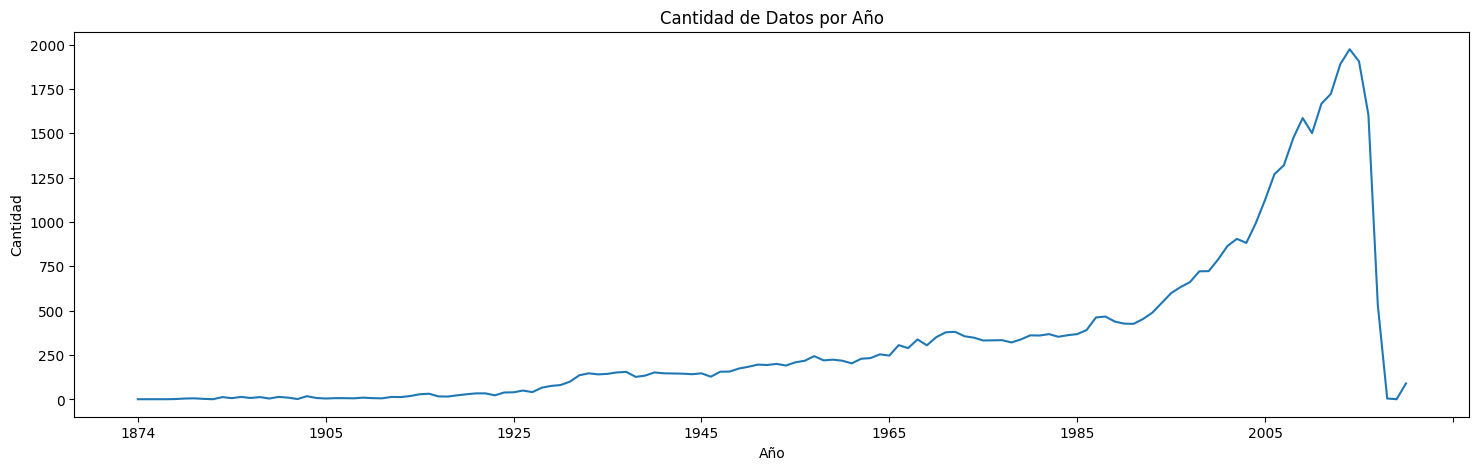

In [32]:
year_count = df.groupby('year')['title'].count()
plt.figure(figsize=(18,5))
evolucion_data=year_count.plot()

evolucion_data.set_xlabel('Year')
evolucion_data.set_ylabel('Amount')
evolucion_data.set_title('Amount of Data per Year')


In [33]:
year_count.tail(10)

year
2011    1667
2012    1722
2013    1889
2014    1974
2015    1905
2016    1604
2017     532
2018       5
2020       1
NaT       90
Name: title, dtype: int64

### Movie Duration


In [34]:
df[(df['runtime'] <= 0)]

,belongs_to_collection,budget,genres,homepage,id,original_language,overview,popularity,poster_path,production_companies,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,primary_genre,return,year
222,NaN,NaN,"[{'id': 53, 'name': 'Thriller'}]",NaN,61813,en,Kris is a homicide cop with psychic abilities....,0.155859,/7JbvfOA2hnWkSIJslAayK0AemDU.jpg,"[{'name': 'Keystone Pictures', 'id': 15709}, {...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Dream Man,False,2.5,1.0,Thriller,NaN,1995
224,NaN,NaN,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",NaN,62488,it,Johnny Destiny burns into Las Vegas in his hot...,0.710671,/9iczUcmMLnOZ4Ltx3X3AEpbxTt4.jpg,"[{'name': 'Savoy Pictures', 'id': 11308}, {'na...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Fate visits in ways you never expect,Destiny Turns on the Radio,False,5.3,9.0,Crime,NaN,1995
398,NaN,NaN,[],NaN,172923,en,Greed and playing into the hand of providence ...,0.233376,/1L15fJfWfOUK9Ht15OLLmgW90h8.jpg,[],...,[],Released,NaN,Dos Crímenes,False,5.0,1.0,Unknown,NaN,1995
554,NaN,NaN,[],NaN,218473,en,"The Beans are poor, proud, hated by all, but a...",0.382470,NaN,[],...,[],Released,NaN,"The Beans of Egypt, Maine",False,NaN,1.0,Unknown,NaN,1994
667,NaN,NaN,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,221917,en,An Irish lad (Matt Keeslar) who fled from his ...,0.117662,/ngOBDDwr5CpzFx9IJljq1CfOGt3.jpg,"[{'name': 'Castle Rock Entertainment', 'id': 9...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,An unforgettable romance,The Run of the Country,False,8.0,2.0,Drama,NaN,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45370,NaN,NaN,"[{'id': 18, 'name': 'Drama'}]",NaN,374764,es,Celina works at a remote tollbooth on a desert...,0.274793,/cMsD2BSDgXuHceypiKc0jW5r7Iz.jpg,"[{'name': 'Tarea Fina', 'id': 64499}]",...,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,NaN,How Most Things Work,False,6.8,2.0,Drama,NaN,2015
45371,"{'id': 477208, 'name': 'DC Super Hero Girls Co...",NaN,"[{'id': 16, 'name': 'Animation'}]",NaN,460135,en,"When Supergirl, Wonder Woman, Batgirl, Bumbleb...",8.413734,/niLX2txdI5GlVowJlnb5Hr26QpK.jpg,"[{'name': 'Warner Bros. Animation', 'id': 2785}]",...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,LEGO DC Super Hero Girls: Brain Drain,False,10.0,2.0,Animation,NaN,2017
45399,NaN,750000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",NaN,280422,ru,nan,0.201582,/hNsmPpl3zLG36jr4EIEd5P8I4pa.jpg,"[{'name': 'Кинокомпания «Lunapark»', 'id': 420...",...,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,All at Once,False,6.0,4.0,Crime,0.000004,2014
45416,NaN,NaN,"[{'id': 35, 'name': 'Comedy'}]",NaN,282308,en,After visiting the first Cubist exposition in ...,0.003732,/rGi2o6TDQhiYeaYQqPQkwKx8qfJ.jpg,"[{'name': 'Pathé Frères', 'id': 21594}]",...,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,NaN,"Whiffles, Cubic Artist",False,NaN,0.0,Comedy,NaN,1912


In [35]:
#imputamos con la mediana los <= 0
mediana = df['runtime'].median()

df.loc[df['runtime'] <= 0, 'runtime'] = mediana

<Axes: xlabel='runtime', ylabel='Density'>

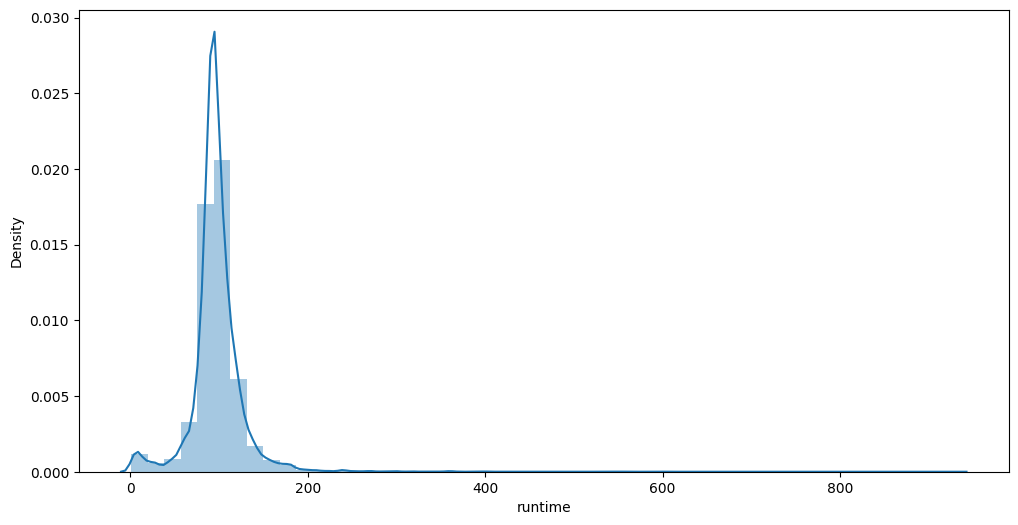

In [36]:
plt.figure(figsize=(12,6))

sns.distplot(df[(df['runtime'] < 1000)]['runtime'])

In [37]:
df['year'] = pd.to_numeric(df['year'], errors='coerce')

In [38]:
'''  df['year'] = pd.to_datetime(df['year'], errors='coerce').dt.year


 plt.figure(figsize=(18,5))
 year_runtime = df[df['year'] != 'NaT'].groupby('year')['runtime'].mean()
 plt.plot(year_runtime.index, year_runtime)

# # Plot the data
 plt.plot(year_runtime.index, year_runtime)


# # Extract the year part from the datetime objects
 start_year = year_runtime.index.min().year
 end_year = year_runtime.index.max().year

# # Generate ticks for every ten years
 ticks = pd.date_range(start=f'{start_year}', end=f'{end_year}', freq='10YS')

# # Set x-axis ticks
 plt.xticks(ticks)

 plt.show() '''

"  df['year'] = pd.to_datetime(df['year'], errors='coerce').dt.year\n\n\n plt.figure(figsize=(18,5))\n year_runtime = df[df['year'] != 'NaT'].groupby('year')['runtime'].mean()\n plt.plot(year_runtime.index, year_runtime)\n\n# # Plot the data\n plt.plot(year_runtime.index, year_runtime)\n\n\n# # Extract the year part from the datetime objects\n start_year = year_runtime.index.min().year\n end_year = year_runtime.index.max().year\n\n# # Generate ticks for every ten years\n ticks = pd.date_range(start=f'{start_year}', end=f'{end_year}', freq='10YS')\n\n# # Set x-axis ticks\n plt.xticks(ticks)\n\n plt.show() "

### Top-Grossing Movies

In [39]:
df[(df['return'].notnull()) & (df['budget'] > 5e6)][['title', 'budget', 'revenue', 'return', 'year']].sort_values('return', ascending=False).head(10)

#meter infograpghic

,title,budget,revenue,return,year
1065,E.T. the Extra-Terrestrial,10500000.0,792965326.0,75.520507,1982.0
256,Star Wars,11000000.0,775398007.0,70.490728,1977.0
1338,Jaws,7000000.0,470654000.0,67.236286,1975.0
1888,The Exorcist,8000000.0,441306145.0,55.163268,1973.0
352,Four Weddings and a Funeral,6000000.0,254700832.0,42.450139,1994.0
834,The Godfather,6000000.0,245066411.0,40.844402,1972.0
4492,Look Who's Talking,7500000.0,296000000.0,39.466667,1989.0
24258,Annabelle,6500000.0,255273813.0,39.272894,2014.0
1056,Dirty Dancing,6000000.0,213954274.0,35.659046,1987.0
1006,The Sound of Music,8200000.0,286214286.0,34.904181,1965.0


### Genre

This code performs the following steps:

Transforms a column with lists of genres: It unpacks each list of genres, where genres are in dictionary format, so that each genre has its own row in the DataFrame.

Counts the total number of unique genres: After reorganizing the genres into individual rows, it counts the unique genres in the DataFrame.

In [40]:
import ast

def convert_genre(entry):
    # If the entry is a string, try to convert it using ast.literal_eval
    if isinstance(entry, str):
        try:
            return [d['name'] for d in ast.literal_eval(entry)]
        except ValueError:
            # Handle cases where ast.literal_eval fails to parse the string
            return []
    # If the entry is already a list, extract the genre names
    elif isinstance(entry, list):
        return [d['name'] for d in entry if isinstance(d, dict) and 'name' in d]
    # If the entry is neither a string nor a list, return an empty list
    else:
        return []

# Apply the function to the 'genres' column
df['genres'] = df['genres'].fillna('[]').apply(convert_genre)

# Expanding the list of genre names into separate rows
s = df.apply(lambda x: pd.Series(x['genres']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

# Joining the series of genre names with the original DataFrame without the 'genres' column
gen_df = df.drop('genres', axis=1).join(s)


In [41]:
df['genres']

0         [Animation, Comedy, Family]
1        [Adventure, Fantasy, Family]
2                   [Romance, Comedy]
3            [Comedy, Drama, Romance]
4                            [Comedy]
                     ...             
45461                 [Drama, Family]
45462                         [Drama]
45463       [Action, Drama, Thriller]
45464                              []
45465                              []
Name: genres, Length: 45466, dtype: object

In [42]:
pop_gen = pd.DataFrame(gen_df['genre'].value_counts()).reset_index()
pop_gen.columns = ['genre', 'movies']
pop_gen.head(15)

,genre,movies
0,Drama,20265
1,Comedy,13182
2,Thriller,7624
3,Romance,6735
4,Action,6596
5,Horror,4673
6,Crime,4307
7,Documentary,3932
8,Adventure,3496
9,Science Fiction,3049


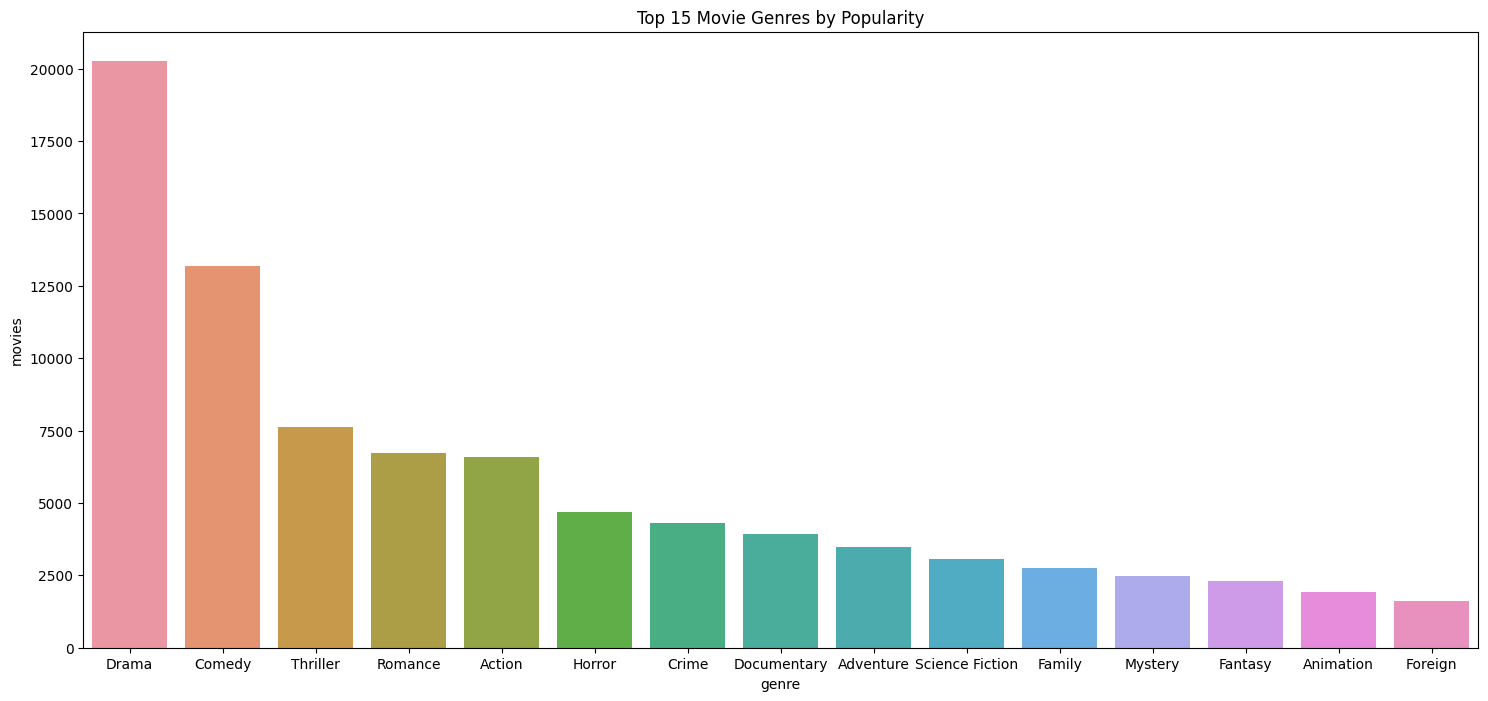

In [43]:
plt.figure(figsize=(18, 8))
sns.barplot(x='genre', y='movies', data=pop_gen.head(15))
plt.title('Top 15 Movie Genres by Popularity')  # Agrega tu título aquí
plt.show()

<Figure size 1800x800 with 0 Axes>

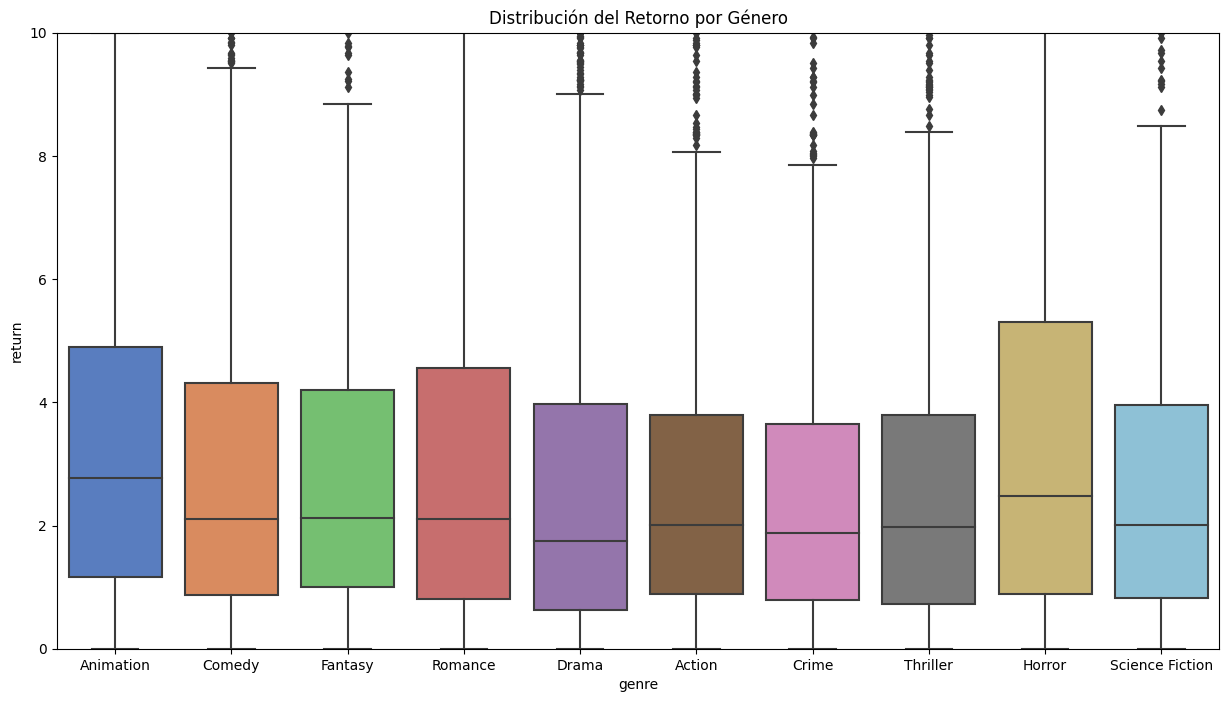

In [44]:
violin_genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Science Fiction', 'Fantasy', 'Animation']
violin_movies = gen_df[(gen_df['genre'].isin(violin_genres))]
plt.figure(figsize=(18,8))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='genre', y='return', data=violin_movies, palette="muted", ax =ax)
ax.set_ylim([0, 10])
plt.title('Return Distribution by Genre')
plt.show()

## Sistemas de recomnadcion

### Recomendacion simple basada en IMBD's weighted average

v is the number of votes for the movie

m is the minimum votes required to be listed in the chart

R is the average rating of the movie

C is the mean vote across the whole report

The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.


I will build our overall Top 250 Chart and will define a function to build charts for a particular genre

In [45]:
from ast import literal_eval

In [46]:
vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.615208892656963

In [47]:
m = vote_counts.quantile(0.80)
m

50.0

In [48]:
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [49]:
qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['id','title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(9150, 7)

In [50]:
qualified_ids = [int(x) for x in qualified['id'].values]
qualified_ids

[862,
 8844,
 15602,
 11862,
 949,
 11860,
 9091,
 710,
 9087,
 12110,
 21032,
 10858,
 1408,
 524,
 4584,
 5,
 9273,
 11517,
 8012,
 1710,
 9691,
 12665,
 451,
 9263,
 902,
 9909,
 63,
 9598,
 687,
 33689,
 9603,
 31174,
 11443,
 9312,
 577,
 807,
 10530,
 629,
 11448,
 11010,
 11359,
 17182,
 2054,
 10607,
 9536,
 10634,
 755,
 11859,
 9102,
 27526,
 9623,
 400,
 10534,
 17414,
 13997,
 2086,
 9095,
 12158,
 9283,
 9208,
 406,
 11062,
 13685,
 9614,
 688,
 10874,
 197,
 103,
 33542,
 11066,
 11104,
 2074,
 27793,
 9101,
 9302,
 11000,
 9737,
 10474,
 568,
 11780,
 414,
 649,
 1775,
 8839,
 20649,
 10329,
 8963,
 26564,
 8068,
 8512,
 1572,
 13552,
 6520,
 9073,
 10428,
 9886,
 9482,
 9344,
 9071,
 8973,
 2293,
 9070,
 1642,
 11472,
 11980,
 32646,
 10533,
 10802,
 10149,
 18402,
 9348,
 281,
 5967,
 36834,
 9090,
 3512,
 9560,
 9804,
 76,
 11017,
 6715,
 2292,
 1909,
 8984,
 4954,
 10531,
 11929,
 8467,
 10451,
 20156,
 522,
 397,
 15789,
 14275,
 1024,
 13701,
 14819,
 11777,
 628,


Therefore, to qualify to be considered for the chart, a movie has to have at least 434 votes on TMDB. We also see that the average rating for a movie on TMDB is 5.244 on a scale of 10. 2274 Movies qualify to be on our chart.



In [51]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

qualified['wr'] = qualified.apply(weighted_rating, axis=1)
qualified = qualified.sort_values('wr', ascending=False).head(250)

#### Top Movies

In [52]:
df.head()

,belongs_to_collection,budget,genres,homepage,id,original_language,overview,popularity,poster_path,production_companies,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,primary_genre,return,year
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,Animation,12.451801,1995
1,NaN,65000000.0,"[Adventure, Fantasy, Family]",NaN,8844,en,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,Adventure,4.043035,1995
2,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",NaN,"[Romance, Comedy]",NaN,15602,en,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,Romance,NaN,1995
3,NaN,16000000.0,"[Comedy, Drama, Romance]",NaN,31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,Comedy,5.090760,1995
4,"{'id': 96871, 'name': 'Father of the Bride Col...",NaN,[Comedy],NaN,11862,en,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,Comedy,NaN,1995


In [53]:
qualified.head(15)

,id,title,year,vote_count,vote_average,popularity,genres,wr
10309,19404,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,"[Comedy, Drama, Romance]",8.761970
15480,27205,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.991558
12481,155,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.990321
22879,157336,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.989389
2843,550,Fight Club,1999,9678,8,63.869599,[Drama],7.987743
4863,120,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.986665
292,680,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.986326
314,278,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.985818
7000,122,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.985592
351,13,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.985453


In [54]:
s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_df = df.drop('genres', axis=1).join(s)

In [55]:
def build_chart(genre, percentile=0.90):
    df = gen_df[gen_df['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)

    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')

    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)

    return qualified

In [56]:
gen_df.head()

,belongs_to_collection,budget,homepage,id,original_language,overview,popularity,poster_path,production_companies,production_countries,...,status,tagline,title,video,vote_average,vote_count,primary_genre,return,year,genre
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,http://toystory.disney.com/toy-story,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",...,Released,NaN,Toy Story,False,7.7,5415.0,Animation,12.451801,1995,Animation
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,http://toystory.disney.com/toy-story,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",...,Released,NaN,Toy Story,False,7.7,5415.0,Animation,12.451801,1995,Comedy
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,http://toystory.disney.com/toy-story,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",...,Released,NaN,Toy Story,False,7.7,5415.0,Animation,12.451801,1995,Family
1,NaN,65000000.0,NaN,8844,en,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,Adventure,4.043035,1995,Adventure
1,NaN,65000000.0,NaN,8844,en,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,Adventure,4.043035,1995,Fantasy


In [57]:
df.head()

,belongs_to_collection,budget,genres,homepage,id,original_language,overview,popularity,poster_path,production_companies,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,primary_genre,return,year
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,Animation,12.451801,1995
1,NaN,65000000.0,"[Adventure, Fantasy, Family]",NaN,8844,en,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,Adventure,4.043035,1995
2,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",NaN,"[Romance, Comedy]",NaN,15602,en,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,Romance,NaN,1995
3,NaN,16000000.0,"[Comedy, Drama, Romance]",NaN,31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,Comedy,5.090760,1995
4,"{'id': 96871, 'name': 'Father of the Bride Col...",NaN,[Comedy],NaN,11862,en,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,Comedy,NaN,1995


In [58]:
build_chart('Drama').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.388326
12481,The Dark Knight,2008,12269,8,123.167259,7.972302
22879,Interstellar,2014,11187,8,32.213481,7.969659
2843,Fight Club,1999,9678,8,63.869599,7.965003
314,The Shawshank Redemption,1994,8358,8,51.645403,7.959576
351,Forrest Gump,1994,8147,8,48.307194,7.958549
834,The Godfather,1972,6024,8,41.109264,7.944307
24860,The Imitation Game,2014,5895,8,31.595940,7.943120
359,The Lion King,1994,5520,8,21.605761,7.939361
18465,The Intouchables,2011,5410,8,16.086919,7.938163


The recommender we built in the previous section suffers some severe limitations. For one, it gives the same recommendation to everyone, regardless of the user's personal taste. If a person who loves romantic movies (and hates action) were to look at our Top 15 Chart, s/he wouldn't probably like most of the movies. If s/he were to go one step further and look at our charts by genre, s/he wouldn't still be getting the best recommendations.


For instance, consider a person who loves Dilwale Dulhania Le Jayenge, My Name is Khan and Kabhi Khushi Kabhi Gham. One inference we can obtain is that the person loves the actor Shahrukh Khan and the director Karan Johar. Even if s/he were to access the romance chart, s/he wouldn't find these as the top recommendations.

### Model Based Recommender Systems


Model-based recommendation systems involve building a model based on the dataset of ratings. In other words, we extract some information from the dataset, and use that as a "model" to make recommendations without having to use the complete dataset every time.


For model based recommender systems we are going to use a library called Surprise and we are going to use SVD as a matrix factorization method.

Singular Value Decomposition (SVD)

Singular Value Decomposition (SVD) is one of the matrix factorization method in machine learning. Singular value decomposition decomposes a matrix into three other matrices and extracts the features from the factorization of a high-level (user-item-rating) matrix.

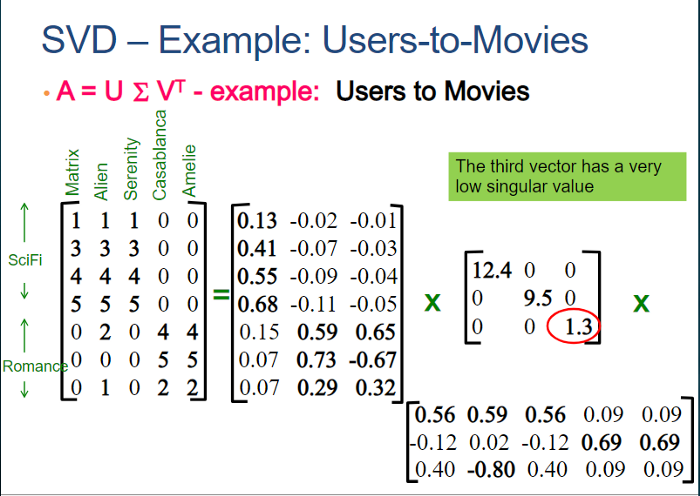

The formula of SVD can be given as: A = USV ^ t

Matrix U: Latent features of Users

Matrix S: Diagonal matrix representing the strength of each feature

Matrix U: Latent features of Items


In [63]:
from surprise import Dataset, Reader

from surprise.prediction_algorithms.matrix_factorization import SVD

from surprise import accuracy

from surprise.model_selection import cross_validate

from surprise import NormalPredictor



In [64]:
df = df.drop([19730, 29503, 35587]) #estos tienen fechas en los id's
df.reset_index(inplace=True, drop=True)


In [65]:
links = pd.read_csv('links.csv')

links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [66]:
ratings_small = pd.read_csv('ratings_small.csv')

ratings_small.head()

ratings_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [67]:
# seleccionamos los rating de las pelicuals que estan clasificadas segun el weighted avg

ratings_small = ratings_small[ratings_small['movieId'].isin(qualified_ids)]
ratings_small.reset_index(inplace=True, drop=True)
ratings_small.shape

(30581, 4)

In [68]:
# Initialize a surprise reader object
reader = Reader(line_format='user item rating', sep=',', rating_scale=(0,5), skip_lines=1)

# Load the data
data = Dataset.load_from_df(ratings_small[['userId','movieId','rating']], reader=reader)

trainset = data.build_full_trainset()

# df para los result
results_df = pd.DataFrame(columns=[ 'Tipo sist recom'  ,'Algoritmo', 'Average MAE', 'Average RMSE', 'Paramaetrs'])

In [69]:
# Baseline algorithm - user-based
print("Evaluating User-Based Baseline...")

random = NormalPredictor()

results = cross_validate(random, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# RMSE and MAE
rmse = results['test_rmse'].mean()
mae = results['test_mae'].mean()

print(f'Average RMSE: {rmse}')
print(f'Average MAE: {mae}')
results_df = results_df.append({'Tipo sist recom': 'Model Based','Algoritmo': 'NormalPredictor','Average MAE': mae, 'Average RMSE': rmse }, ignore_index = True )

results_df

Evaluating User-Based Baseline...
Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4389  1.4325  1.4161  1.4448  1.4372  1.4339  0.0098  
MAE (testset)     1.1411  1.1462  1.1357  1.1516  1.1453  1.1440  0.0053  
Fit time          0.05    0.06    0.06    0.06    0.06    0.06    0.00    
Test time         0.04    0.04    0.04    0.05    0.04    0.04    0.00    
Average RMSE: 1.4339008625282532
Average MAE: 1.1439629978907828


,Tipo sist recom,Algoritmo,Average MAE,Average RMSE,Paramaetrs
0,Model Based,NormalPredictor,1.143963,1.433901,NaN


In [70]:
from surprise.model_selection import GridSearchCV
from surprise import SVD
param_grid = {"n_epochs": [10, 15, 20], "lr_all": [0.002, 0.005, 0.001], "reg_all": [0.2, 0.4, 0.6]}

gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5)

gs.fit(data)

# RMSE and MAE
rmse = gs.best_score['rmse'].mean()
mae = gs.best_score['mae'].mean()

print(f'Average RMSE: {rmse}')
print(f'Average MAE: {mae}')

print(f'best parms: {gs.best_params["rmse"]}')

results_df = results_df.append({'Tipo sist recom': 'Model Based','Algoritmo': 'SVD','Average MAE': mae, 'Average RMSE': rmse }, ignore_index = True )

results_df

Average RMSE: 0.8929480481087773
Average MAE: 0.6916088292897313
best parms: {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}


,Tipo sist recom,Algoritmo,Average MAE,Average RMSE,Paramaetrs
0,Model Based,NormalPredictor,1.143963,1.433901,NaN
1,Model Based,SVD,0.691609,0.892948,NaN


In [71]:
# Train a new model with the best parameters
best_params = gs.best_params['rmse']
best_svd = SVD(n_epochs=best_params['n_epochs'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])

best_svd.fit(trainset)

In [72]:

import joblib

best_params_svd = gs.best_params['rmse']
with open('best_params_svd.json', 'w') as fp:
    json.dump(best_params_svd, fp)

In [73]:
from surprise import CoClustering

# Co-Clustering
co_clustering = CoClustering()
results_co_clustering = cross_validate(co_clustering, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# RMSE and MAE
rmse = results_co_clustering['test_rmse'].mean()
mae = results_co_clustering['test_mae'].mean()

print(f'Average RMSE: {rmse}')
print(f'Average MAE: {mae}')


results_df = results_df.append({'Tipo sist recom': 'Model Based','Algoritmo': 'CoClustering','Average MAE': mae, 'Average RMSE': rmse }, ignore_index = True )

results_df

Evaluating RMSE, MAE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9514  0.9589  0.9449  0.9554  0.9415  0.9504  0.0065  
MAE (testset)     0.7390  0.7445  0.7320  0.7413  0.7288  0.7371  0.0059  
Fit time          0.97    0.99    0.93    0.70    0.68    0.85    0.13    
Test time         0.05    0.05    0.05    0.03    0.03    0.04    0.01    
Average RMSE: 0.9504335413332082
Average MAE: 0.7371270604900195


,Tipo sist recom,Algoritmo,Average MAE,Average RMSE,Paramaetrs
0,Model Based,NormalPredictor,1.143963,1.433901,NaN
1,Model Based,SVD,0.691609,0.892948,NaN
2,Model Based,CoClustering,0.737127,0.950434,NaN


When are using .predict() method where we are passing 3 arguments,i.e. userID(uid), itemID(iid) and r_ui(true rating)


The output of each prediction is a tuple where est is our estimated ratings.


We can see that our model is able to perform good and is able to make good predictions. However, this model can be further improved by using hyperparameter optimization techinique.


Now that our models is ready we will be filling the user-item interaction matrix and will be making recommendations.

In [74]:
import requests

def fetch_movie_details_from_api(movie_title):
    # Replace 'your_api_key' with the actual API key and 'api_url' with the actual API URL
    api_key = 'eea512d98795e39919db1ca19ebd4530'
    api_url = f'https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={movie_title}'
    response = requests.get(api_url)
    data = response.json()
    if data['results']:
        # Extract the first result or use a loop to find the best match
        movie_data = data['results'][0]
        return {
            'poster_path': f"https://image.tmdb.org/t/p/original{movie_data['poster_path']}",
            'vote_average': movie_data['vote_average'],
            'genres': movie_data['genre_ids']  # You might need to map genre IDs to genre names
        }
    else:
        # Return default values if the movie is not found
        return {
            'poster_path': 'default_poster_url',
            'vote_average': 'N/A',
            'genres': 'Unknown'
        }

In [75]:
def get_recommendations(data, movie_metadata, user_id, top_n, algo):
    recommendations = []

    # Ensure 'id' in movie_metadata is integer (or the same type as item_id in your algorithm)
    movie_metadata['id'] = movie_metadata['id'].astype(int)

    # Create user-item interactions matrix
    user_movie_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')

    # Find movies the user hasn't interacted with
    non_interacted_movies = user_movie_interactions_matrix.loc[user_id][user_movie_interactions_matrix.loc[user_id].isnull()].index.tolist()

    for item_id in non_interacted_movies:
        # Predict the rating
        est = algo.predict(user_id, item_id).est

        # Find the movie title
        matched_movies = movie_metadata[movie_metadata['id'] == item_id]['title']


        if not matched_movies.empty:
            movie_name = matched_movies.iloc[0]
        else:
            movie_name = 'Unknown'

        movie_details = fetch_movie_details_from_api(movie_name)

        recommendations.append((movie_name, est, movie_details['poster_path'], movie_details['vote_average'], movie_details['genres']))

    recommendations.sort(key=lambda x: x[1], reverse=True)
    return recommendations[:top_n]


In [76]:
df = df.drop([19730, 29503, 35587]) #estos tienen fechas en los id's
df.reset_index(inplace=True, drop=True)

In [77]:
get_recommendations(data = ratings_small, movie_metadata=df, user_id=400, top_n=10, algo=best_svd)

[('Sleepless in Seattle',
  4.429127665000827,
  'https://image.tmdb.org/t/p/original/iLWsLVrfkFvOXOG9PbUAYg7AK3E.jpg',
  6.734,
  [35, 18, 10749]),
 ('Galaxy Quest',
  4.401108069344564,
  'https://image.tmdb.org/t/p/original/fZXSwgZknp81vmciTb86rw0MejV.jpg',
  7.064,
  [35, 878, 12]),
 ('The Thomas Crown Affair',
  4.327775960570006,
  'https://image.tmdb.org/t/p/original/5yqs1MVlqdIg1DY5adC5jFx3d7j.jpg',
  6.734,
  [18, 80, 10749]),
 ('Nell',
  4.323097603264968,
  'https://image.tmdb.org/t/p/original/aIDp3x2YfijtdherR28pIH6yenn.jpg',
  6.533,
  [18, 53]),
 ('Lonely Hearts',
  4.321324228743208,
  'https://image.tmdb.org/t/p/original/qnQK4JUwEUFDKt7dSMY2fJmhv2f.jpg',
  6.025,
  [18, 53, 80, 10749]),
 ('Hard Target',
  4.30037142203956,
  'https://image.tmdb.org/t/p/original/kufvuQYWdl82sYzmhy2naBLyMui.jpg',
  6.3,
  [28, 12, 80, 53]),
 ('While You Were Sleeping',
  4.297483823805343,
  'https://image.tmdb.org/t/p/original/xrXUADqC2gt84BPYzNtXxAJEfbo.jpg',
  6.968,
  [10749, 35]),
 (

### Memory Based Recommender System

Memory-based methods use user rating historical data to compute the similarity between users or items. The idea behind these methods is to define a similarity measure between users or items, and find the most similar to recommend unseen items. Memory based recommender systems are of 2 types -


User-Based


Item-Bassed

#### User-Based

In user based recommendation method we will be computing similarities between users and will fetch the most similar users using an algorithm(KNN) and will recommend movies which one user likes to another user and vice versa


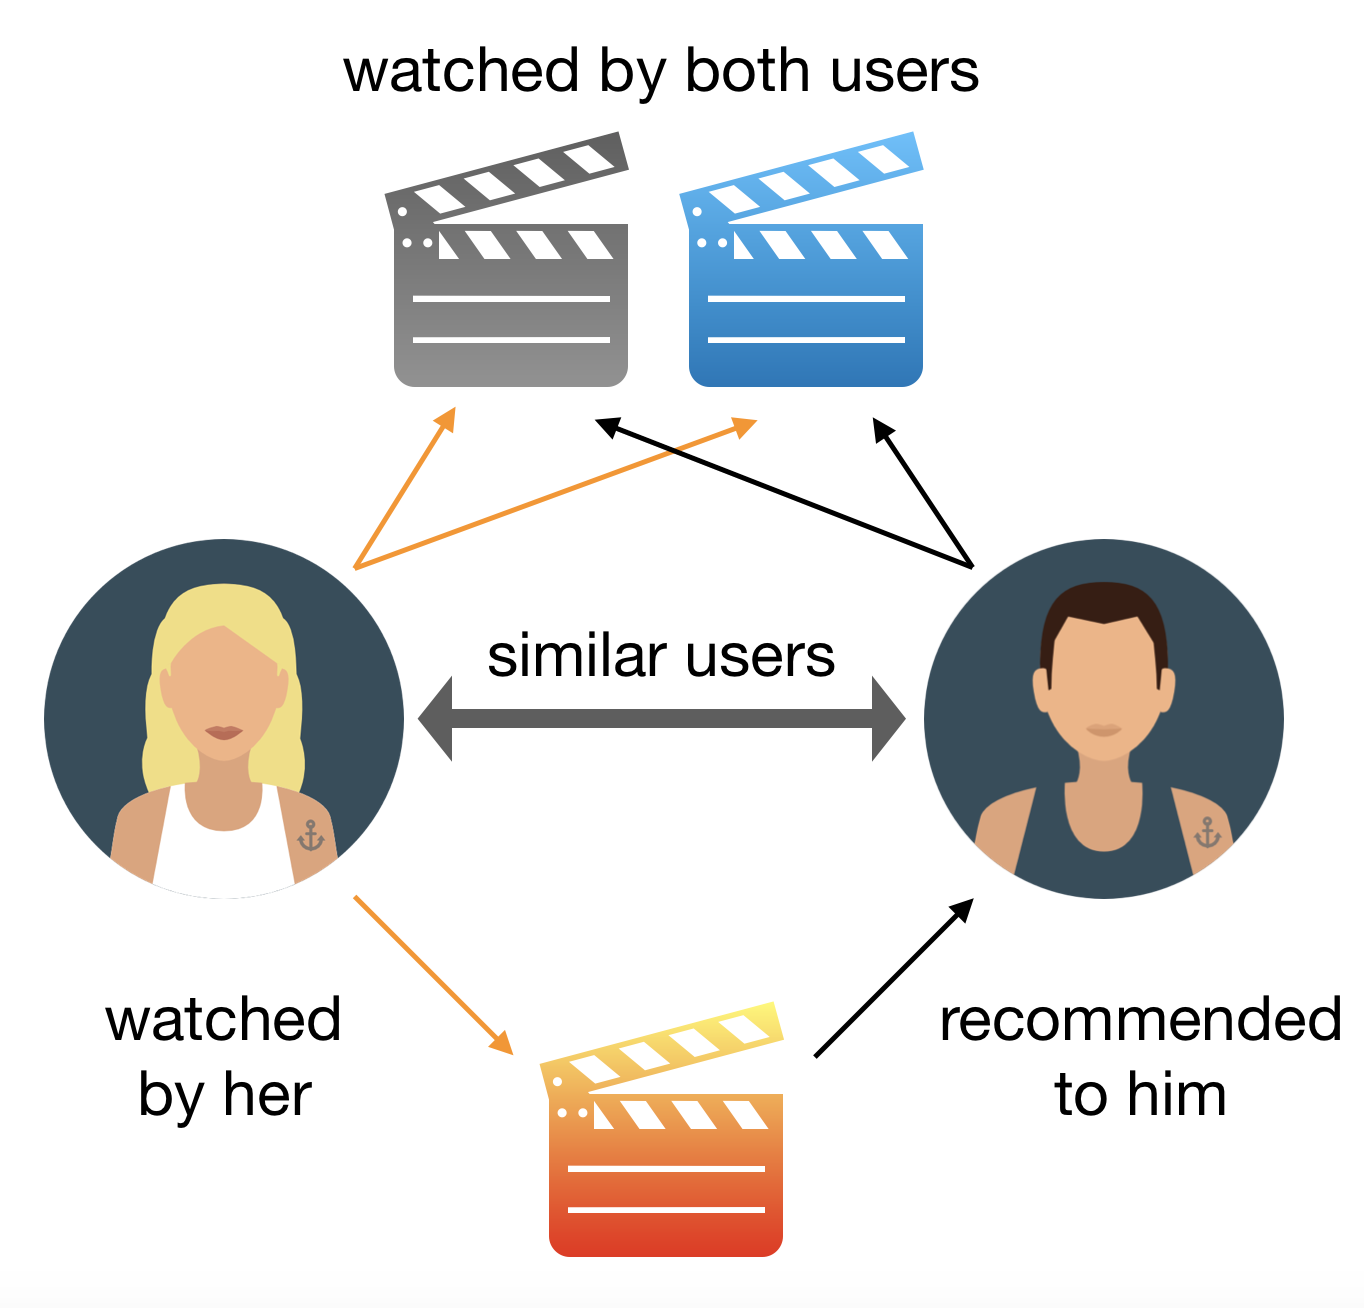


In [78]:
data

In [79]:
from surprise import Dataset, Reader
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms.knns import KNNBasic


# Define the parameter grid
param_grid_user = {
    'k': [20, 30, 40],
    'sim_options': {
        'name': ['msd', 'cosine', 'pearson'],
        'user_based': [True]
    }
}

# Perform grid search
gs_user = GridSearchCV(KNNBasic, param_grid_user, measures=['RMSE', 'MAE'], cv=5)
gs_user.fit(data)

# Best score and parameters
print(f'Best RMSE: {gs_user.best_score["rmse"]}')
print(f'Best MAE: {gs_user.best_score["mae"]}')
print(f'Best parameters: {gs_user.best_params["rmse"]}')

# Update results_df
results_df = pd.DataFrame()
results_df = results_df.append({'Tipo sist recom': 'Memory-based CF (User-Based)', 'Algoritmo': 'KNNBasic', 'Average MAE': gs_user.best_score["mae"], 'Average RMSE': gs_user.best_score["rmse"], 'Parameters': gs_user.best_params["rmse"]}, ignore_index=True)

best_params = gs_user.best_params['rmse']
best_user_model = KNNBasic(k=best_params['k'], sim_options=best_params['sim_options'])
best_user_model.fit(trainset)

# Display the updated DataFrame
print(results_df)


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson si

In [80]:
get_recommendations(ratings_small, df, 50
                    ,10,best_user_model)

[('The Wizard',
  5,
  'https://image.tmdb.org/t/p/original/dtgNNq3TBbpBX6RXHLt5gAMdwPV.jpg',
  6.007,
  [12, 35, 18, 10751]),
 ('Rio Bravo',
  5,
  'https://image.tmdb.org/t/p/original/92hYmHw1XpMEF7yZUzjOzcO4zmC.jpg',
  4.3,
  [37, 28]),
 ('The Celebration',
  5,
  'https://image.tmdb.org/t/p/original/6l2vIvzcNoNnx1rZ23jszNFIfHr.jpg',
  10.0,
  [18]),
 ('Spider-Man 3',
  5,
  'https://image.tmdb.org/t/p/original/qFmwhVUoUSXjkKRmca5yGDEXBIj.jpg',
  6.402,
  [14, 28, 12]),
 ('A Streetcar Named Desire',
  5,
  'https://image.tmdb.org/t/p/original/aicdlO5vt7z2ARm279eGzJeYCLQ.jpg',
  7.649,
  [18]),
 ('Gentlemen Prefer Blondes',
  5,
  'https://image.tmdb.org/t/p/original/fDozhst5HVJJcd3BM8ZOsKniO7Q.jpg',
  7.321,
  [35, 10749]),
 ('The Evil Dead',
  5,
  'https://image.tmdb.org/t/p/original/9kwlaaJVKMX1SvsX2F1y0sRDuMs.jpg',
  7.3,
  [27]),
 ('JFK',
  5,
  'https://image.tmdb.org/t/p/original/r0VWVTYlqdRCK5ZoOdNnHdqM2gt.jpg',
  7.603,
  [18, 53, 36]),
 ('Strangers on a Train',
  5,
  'htt

In [81]:
best_params_user = gs_user.best_params['rmse']
with open('best_params_user.json', 'w') as fp:
    json.dump(best_params_user, fp)

#### Item Based

In item based recommendation method we will be computing similarities between items(movies) and will fetch the most similar items(movies) using an algorithm(KNN) and will recommend items(movies) which one user likes to another user who likes similar kind of item(movie) and vice versa.

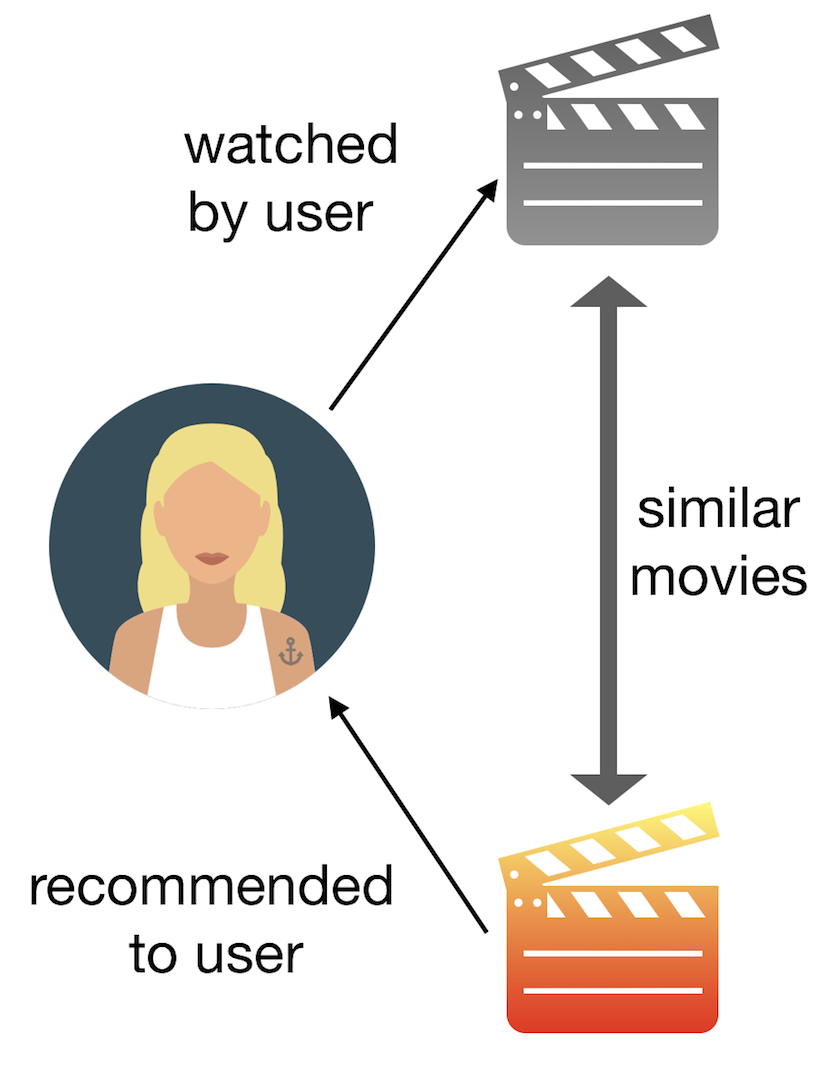


In [82]:
# Define the parameter grid
param_grid_item = {
    'k': [20, 30, 40],
    'sim_options': {
        'name': ['msd', 'cosine', 'pearson'],
        'user_based': [False]
    }
}

# Perform grid search
gs_item = GridSearchCV(KNNBasic, param_grid_item, measures=['RMSE', 'MAE'], cv=5)
gs_item.fit(data)

# Best score and parameters
print(f'Best RMSE: {gs_item.best_score["rmse"]}')
print(f'Best MAE: {gs_item.best_score["mae"]}')
print(f'Best parameters: {gs_item.best_params["rmse"]}')

# Update results_df
results_df = results_df.append({'Tipo sist recom': 'Memory-based CF (Item-Based)', 'Algoritmo': 'KNNBasic', 'Average MAE': gs_item.best_score["mae"], 'Average RMSE': gs_item.best_score["rmse"], 'Parameters': gs_item.best_params["rmse"]}, ignore_index=True)

best_params = gs_item.best_params['rmse']
best_item_model = KNNBasic(k=best_params['k'], sim_options=best_params['sim_options'])
best_item_model.fit(trainset)


# Display the updated DataFrame
print(results_df)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson si

In [83]:
get_recommendations(ratings_small, df, 671,10,best_item_model)

[('Hard Candy',
  5,
  'https://image.tmdb.org/t/p/original/uHTmlcivbPeclEdmtuQg3zOQWPS.jpg',
  6.815,
  [18, 53]),
 ('Visitor Q',
  5,
  'https://image.tmdb.org/t/p/original/veDqVt4oYq6mjFGasdVeEv6RPBg.jpg',
  6.405,
  [35, 18, 27, 53]),
 ('Daisies',
  4.625000000000001,
  'https://image.tmdb.org/t/p/originalNone',
  0.0,
  []),
 ('The Protector',
  4.566666666666667,
  'https://image.tmdb.org/t/p/original/vlpJXIFYF0m0TFdtYXb8YmNMBhV.jpg',
  4.0,
  [53, 14]),
 ('Michael Clayton',
  4.5338622787608545,
  'https://image.tmdb.org/t/p/original/hhkW4yVIGo8Bee3UITKvqOvhNMG.jpg',
  6.767,
  [18, 53, 9648, 80]),
 ('Shaun of the Dead',
  4.524590163934427,
  'https://image.tmdb.org/t/p/original/dgXPhzNJH8HFTBjXPB177yNx6RI.jpg',
  7.5,
  [27, 35]),
 ('Junebug',
  4.5,
  'https://image.tmdb.org/t/p/original/asC6UOPrR6OlNMiyXbeXWu08SOG.jpg',
  6.622,
  [35, 18]),
 ("Hearts of Darkness: A Filmmaker's Apocalypse",
  4.5,
  'https://image.tmdb.org/t/p/original/nVMCtL3r2nj4fySihDDvamaVkfx.jpg',
  7.8

In [84]:
best_params_item = gs_item.best_params['rmse']
with open('best_params_item.json', 'w') as fp:
    json.dump(best_params_item, fp)


#### Content Based

importamos librerias

In [85]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')


In [87]:
# Read the movies meta-data(we will be using the feature genre, overview & title from this)
movie_md = pd.read_csv("movies_metadata.csv")

# Read the keywords
movie_keywords = pd.read_csv("keywords.csv")

# Read the credits
movie_credits = pd.read_csv("credits.csv")

In [88]:
movie_md = movie_md[movie_md['vote_count']>=55]
movie_md = movie_md[['id','original_title','overview','genres']]
movie_md['title'] = movie_md['original_title'].copy()
movie_md.reset_index(inplace=True, drop=True)
movie_md.head()

,id,original_title,overview,genres,title
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men
3,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II
4,949,Heat,"Obsessive master thief, Neil McCauley leads a ...","[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Heat


In [89]:
movie_credits = movie_credits[['id','cast']]

###### Data Cleaning & Preprocessing


In [ ]:
# Removing the records for which the id is not available
movie_md = movie_md[movie_md['id'].str.isnumeric()]

Merges

In [90]:
# Merge all dataframe as a single entity
# To merge the ids must be of same datatype
movie_md['id'] = movie_md['id'].astype(int)

# Merge
df = pd.merge(movie_md, movie_keywords, on='id', how='left')

# Reset the index
df.reset_index(inplace=True, drop=True)

In [91]:
# Merge with movie credits
df = pd.merge(df, movie_credits, on='id', how='left')

# Reset the index
df.reset_index(inplace=True, drop=True)

In [92]:
# Lets first start with cleaning the movies metadata
# Fetchin the genre list from the column
df['genres'] = df['genres'].apply(lambda x: [i['name'] for i in eval(x)])

# Replaces spaces in between genre(ex - sci fi to scifi) and make it a string
df['genres'] = df['genres'].apply(lambda x: ' '.join([i.replace(" ","") for i in x]))

In [93]:
# Filling the numm values as []
df['keywords'].fillna('[]', inplace=True)

In [ ]:
# Let's clean the keywords dataframe to extract the keywords
# Fetchin the keyword list from the column
df['keywords'] = df['keywords'].apply(lambda x: [i['name'] for i in eval(x)])

# Remove the expty spaces and join all the keyword wwwith spaces
df['keywords'] = df['keywords'].apply(lambda x: ' '.join([i.replace(" ",'') for i in x]))

In [ ]:
# Filling the numm values as []
df['cast'].fillna('[]', inplace=True)

In [ ]:
# Let's clean the cast dataframe to extract the name of aactors from cast column
# Fetchin the cast list from the column
df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in eval(x)])

# Remove the expty spaces and join all the cast with spaces
df['cast'] = df['cast'].apply(lambda x: ' '.join([i.replace(" ",'') for i in x]))

In [ ]:
df['tags'] = df['overview'] + ' ' + df['genres'] +  ' ' + df['original_title'] + ' ' + df['keywords'] + ' ' + df['cast']

In [ ]:
# Delete useless columns
df.drop(columns=['genres','overview','original_title','keywords','cast'], inplace=True)

In [ ]:
df.isnull().sum()

In [ ]:
df.drop(df[df['tags'].isnull()].index, inplace=True)

In [ ]:
df.drop_duplicates(inplace=True)
df.shape

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Initialize a tfidf object
tfidf = TfidfVectorizer(max_features=5000)

# Transform the data
vectorized_data = tfidf.fit_transform(df['tags'].values)

In [ ]:
vectorized_data

In [ ]:
vectorized_dataframe = pd.DataFrame(vectorized_data.toarray(), index=df['tags'].index.tolist())

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
# Initialize a PCA object
svd = TruncatedSVD(n_components=3000)

# Fit transform the data
reduced_data = svd.fit_transform(vectorized_dataframe)

# Print the shape
reduced_data.shape

In [ ]:
svd.explained_variance_ratio_.cumsum()

###### Recommendation

**Compute a similarity metric on vectors for recommendation**

Now in order to make recommendations we would have to compute any similarity index ex- cosine similarity, eucledian distance, Jaccard distance, etc. here we are going to use cosine similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
similarity = cosine_similarity(reduced_data)

In [ ]:
joblib.dump(similarity, 'similarity.pkl')

In [ ]:
df.to_csv('df_content_based_mod.csv', index=False)

In [ ]:
def recommendation(movie_title):
    id_of_movie = df[df['title']==movie_title].index[0]
    distances = similarity[id_of_movie]
    movie_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x:x[1])[1:20]

    for i in movie_list:
        print(df.iloc[i[0]].title)

In [ ]:
recommendation('The Matrix')

In [ ]:
recommendation('Titanic')

In [ ]:
recommendation('Rocky')

In [ ]:
recommendation('Inception')